<a id="1"> </a>

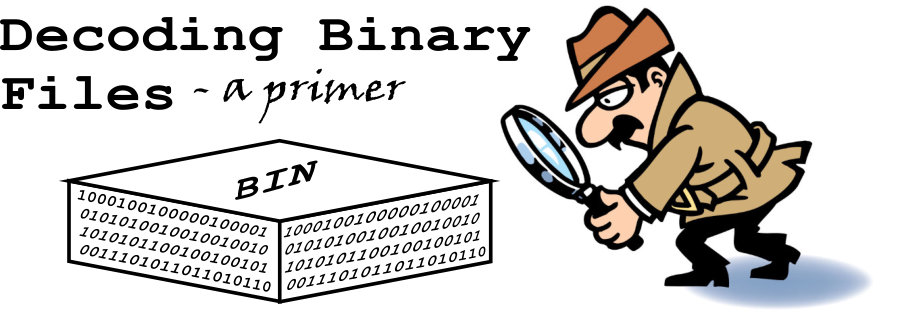

In [ ]:
import struct, os, glob, datetime, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from collections import defaultdict

In [ ]:
# struc library C-structs information
dict_ctype={'c':'char','b':'signed char','B':'unsigned char',
            '?':'_Bool',
            'h':'short','H':'unsigned short','i':'int', 'I':'unsigned int','l':'long','L':'unsigned long',
                    'q':'long long','Q':'unsigned long long',
            'e':'float','f':'float','d':'double'}
dict_pytype_info={'c':'bytes of length 1',
                'b':'int','B':'int',
                '?':'bool',
                'h':'int','H':'int','i':'int','I':'int','l':'int','L':'int','q':'int','Q':'int',
                'e':'float','f':'float','d':'float'}
dict_byteLen = {'c':1,'b':1,'B':1,'?':1,
                 'h':2,'H':2,'i':4,'I':4,
                 'l':4,'L':4,'q':8,'Q':8,
                 'e':2,'f':4,'d':8}
dict_byteOrder_info={'<':'little-endian',
                     '>':'big-endian'}
df_types_lengths=pd.DataFrame([dict_ctype,dict_pytype_info,dict_byteLen])
df_types_lengths=df_types_lengths.T
df_types_lengths.columns=['ctype','pytype','byte_length']
df_types_lengths

In [ ]:
sys.byteorder

<a id="2"> <h3>FILE LIST</h3></a>

In [ ]:
folder=r"C:\decoding_binary_files/files/"
li_files=sorted(glob.glob(folder+"*.*"))
li_files

<a id="7"> <h3>INSPECT THE CSV FILE</h3></a>

In [ ]:
ncsv, nbin = 4,5
# get the data from the CSV file into a Pandas Dataframe
csv_ad=li_files[ncsv]
csv_df=pd.read_csv(csv_ad,sep=';')
# Get the number of Data Points
data_points=len(csv_df)
print(data_points)
csv_df

##### Plot the spectra

In [ ]:
plt.style.use(style='ggplot')
# Store the columns in variables
wls=csv_df[csv_df.columns[0]]
vals=csv_df[csv_df.columns[1]]
spec_name=csv_df.columns[-1]
plt.plot(wls,vals,label=spec_name)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Transmittance')
plt.legend()
plt.show()

### Read in the Raw Binary Data

In [ ]:
bin_fil = li_files[nbin]
print(bin_fil)
# read in the raw binary data
with open(bin_fil, "rb") as fin:
    bin_content = fin.read()
num_bytes=len(bin_content)
print(num_bytes)

In [ ]:
#struct.unpack(byte_order + ctype, bin_content[120:128])
struct.unpack('<f',bin_content[120:124])

<a href="#toc"> TOC</a>

<a id="8"> <h3>LOCATING THE KNOWN VALUES IN THE BINARY DATA</h3></a>

In [ ]:
# Searching for the first 5 values 
for val in vals[:5]:
    for byte_order in ['<','>']:
        for ctype in ['e','f','d']:
            print(val, byte_order+ ctype ,end=' : ')
            byte_len=dict_byteLen[ctype]
            for start_address in range(num_bytes-byte_len+1):
                temp_val=struct.unpack(byte_order + ctype, bin_content[start_address:start_address+byte_len])[0]
                if abs(temp_val-val)<.00001:
                    print(start_address,end=', ')
            print('-'*25)
                

<a href="#9">  <b>BINARY DATA SCANNING ILLUSTRATION</b></a>

### Lets try to locate all the values

In [ ]:
for val in vals:
    for byte_order in ['<']:
        for ctype in ['f']:
            print(val, byte_order+ ctype ,end=' : ')
            byte_len=dict_byteLen[ctype]
            for start_address in range(num_bytes-byte_len+1):
                temp_val=struct.unpack(byte_order + ctype, bin_content[start_address:start_address+byte_len])[0]
                if abs(temp_val-val)<.0001:
                    print(start_address,end=', ')
            print('-'*25)

In [ ]:
for val in wls:
    for byte_order in ['<']:
        for ctype in ['f']:
            print(val, byte_order+ ctype ,end=' : ')
            byte_len=dict_byteLen[ctype]
            for start_address in range(num_bytes-byte_len+1):
                temp_val=struct.unpack(byte_order + ctype, bin_content[start_address:start_address+byte_len])[0]
                if abs(temp_val-val)<.0001:
                    print(start_address,end=', ')
            print('-'*25)

#### Lets store all the info we have so far in a DefaultDict

In [ ]:
summary=defaultdict(list)

In [ ]:
summary['file'].append(bin_fil)
summary['data_points'].append(data_points)
summary['num_bytes'].append(num_bytes)
summary['lowest_wl'].append(14)
summary['highest_wl'].append(10)
#the intermediate wavelengths are missing 
summary['val_at_lowest_wl'].append(2520)
summary['val_at_highest_wl'].append(120)
summary

<a href="#7">  <b>Load next set of CSV/Binary files </b></a>

In [ ]:
dfsummary=pd.DataFrame(summary)
dfsummary

#### Let us summarize what we see so far

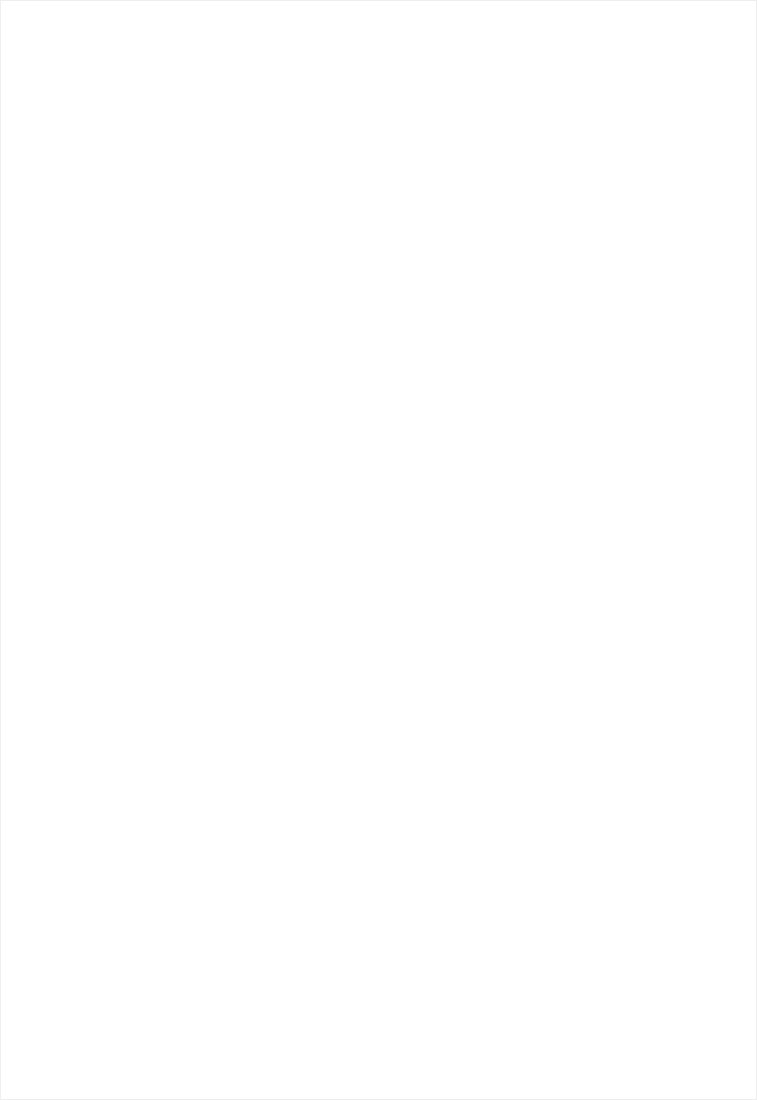

### Summary
- The Highest Wavelength is always found at the same byte address =10
- The lowest Wavelength is also always found at the same byte address =14
- We dont have the intermediate wavelengths
- We dont have the spacing between the wavelengths / the sampling interval 
- The Transmittance values start at the byte address =120 and continue are till the end

##### We can arrive the the number of Data Points from the Binary file data in the following way\

In [ ]:
dfsummary['tmp']=(dfsummary['num_bytes']-dfsummary['val_at_highest_wl'])/4
dfsummary

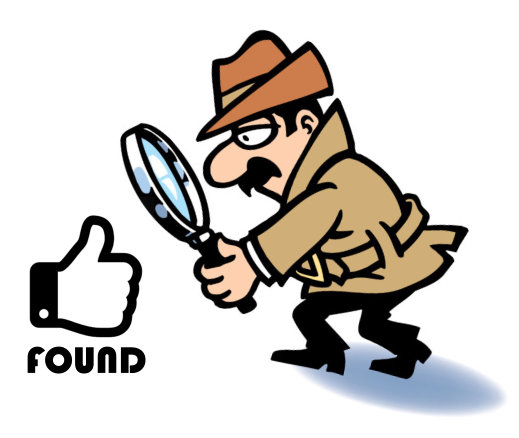

### Now let us try to apply this to the other files

In [ ]:
ncsv, nbin = 8,9
bin_fil = li_files[nbin]
print(bin_fil)
with open(bin_fil, "rb") as fin:
    bin_content = fin.read()
num_bytes=len(bin_content)
print(num_bytes)

##### Highest Wavelength

In [ ]:
struct.unpack('<f', bin_content[10:14])[0]

##### Lowest Wavelength

In [ ]:
struct.unpack('<f', bin_content[14:18])[0]

##### Number of data points

In [ ]:
dpoints=int((num_bytes-120)/4)
dpoints

#### Values in a list

In [ ]:
values=[]
for bin_address in range(120,num_bytes,4):
    values.append(struct.unpack('<f', bin_content[bin_address:bin_address+4])[0])
len(values)

In [ ]:
wls=np.linspace(780,380,dpoints)

### We will now compare the Data to the CSV file data

In [ ]:
csv_ad=li_files[ncsv]
csv_df=pd.read_csv(csv_ad,sep=';')
data_points=len(csv_df)
print(data_points)
csv_df

### Plot the CSV and Binary data

In [ ]:
plt.style.use(style='ggplot')
plt.plot(wls,values,label='Decoded')
spcname=csv_df.columns[-1]
plt.plot(csv_df.wl,csv_df[spcname],label=spcname)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Transmittance')
plt.legend()
plt.show()

In [ ]:
vli=values.copy()
vli.reverse()
df_comp=pd.DataFrame({'wl':csv_df.wl,
                     'csv':csv_df[spcname],
                     'decoded':vli})
df_comp.round(2)

In [ ]:
df_comp['diff']=df_comp.csv-df_comp.decoded
df_comp['diff'].describe()

## Binary file Contents
- Headers
- Data Blocks
- Block Identifiers
- Junk Data

<a id="thanks"> </a>

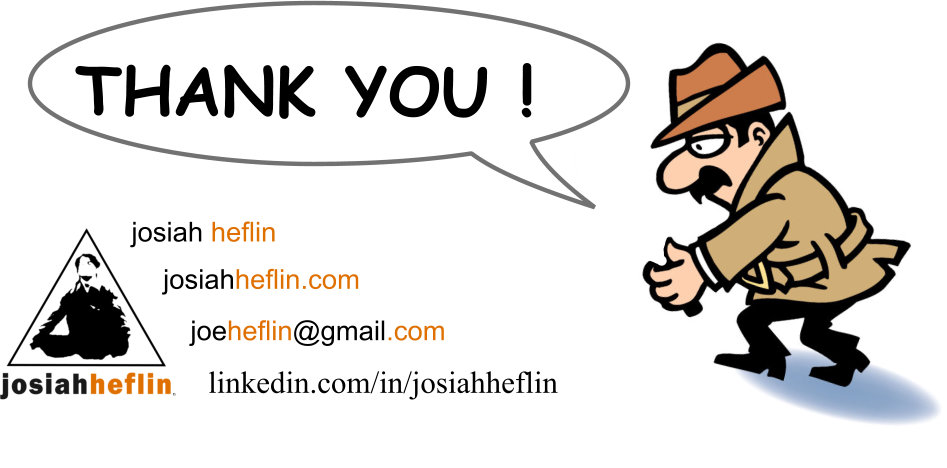

<a id="toc"> <h3>Table of Contents</h3></a>

- <a href="#1">  <b>START</b></a>
- <a href="#2">  <b>FILE LIST</b></a>
- <a href="#3">  <b>3. </b></a>
- <a href="#4">  <b>4. </b></a>
- <a href="#5">  <b>5. </b></a>
- <a href="#6">  <b>6. </b></a>
- <a href="#7">  <b>INSPECT THE CSV FILE </b></a>
- <a href="#8">  <b>LOCATING THE KNOWN VALUES IN THE BINARY DATA</b></a>
- <a href="#9">  <b>BINARY DATA SCANNING ILLUSTRATION</b></a>
- <a href="#10">  <b>Unused code </b></a>


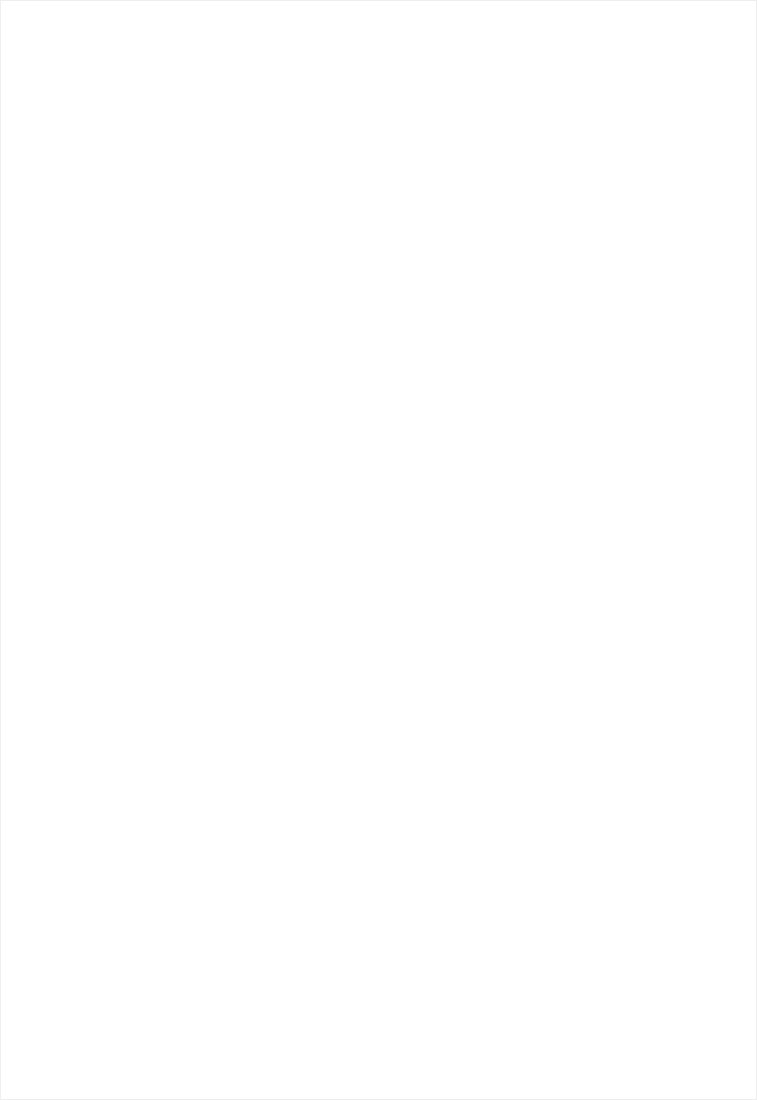

In [ ]:
<a id="toc"> <h3>Table of Contents</h3></a>

<a id="9"> <h3>BINARY DATA SCANNING ILLUSTRATION</h3></a>

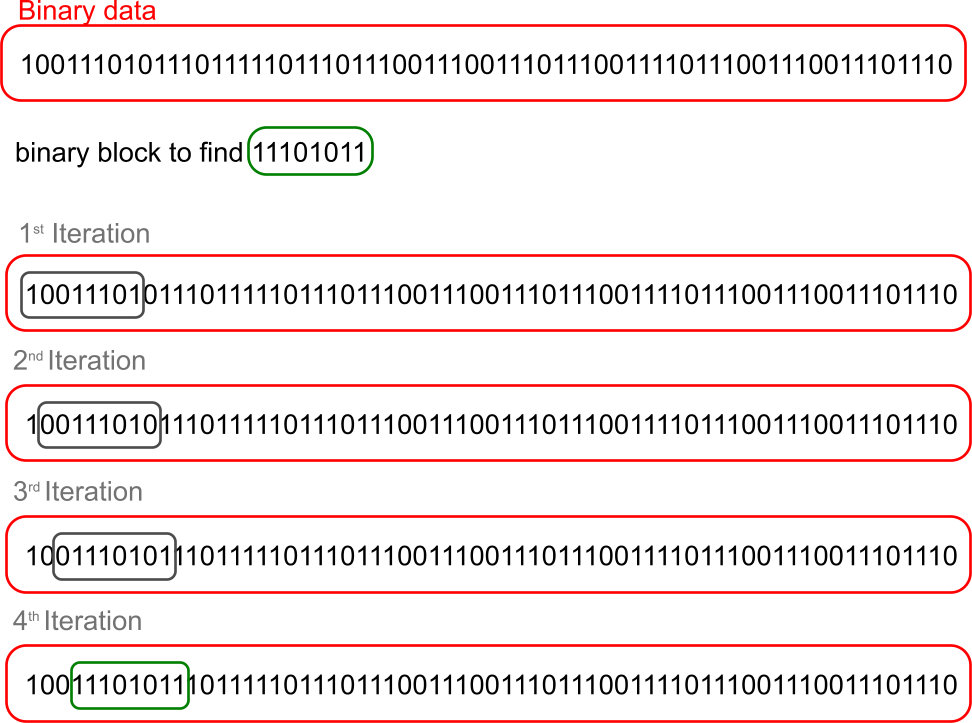

<a href="#8"> <i>go back </i> </a>

<a href="#toc"> TOC</a>

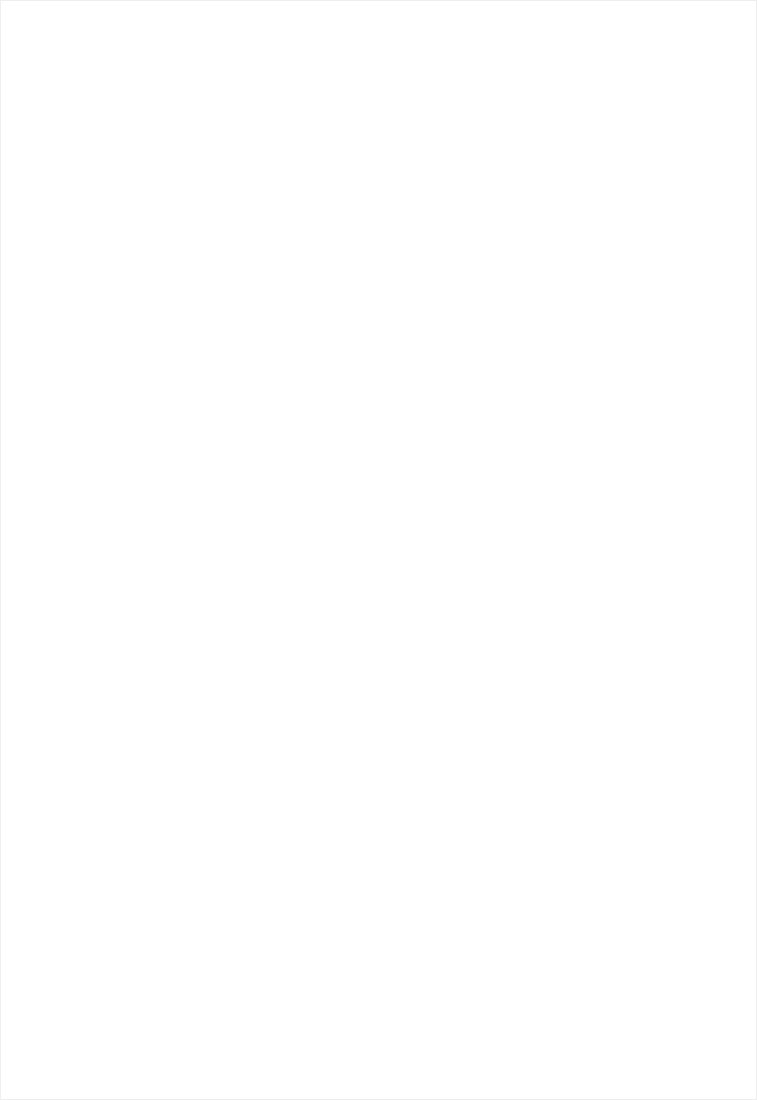

<a id="10"> <h3>UNUSED CODE</h3></a>

In [ ]:
## to Plot all multiple spectra
plt.style.use(style='ggplot')
for spec in [0,2,4]:
    csv_ad=li_files[spec]
    csv_df=pd.read_csv(csv_ad,sep=';')
    wls=csv_df[csv_df.columns[0]]
    spec_name=csv_df.columns[-1]
    yvals=csv_df[spec_name]
    plt.plot(wls,vals,label=spec_name)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Transmittance')
plt.legend()
plt.show()


In [ ]:
bin_content.decode(encoding='iso2022_kr')# utf-8 , latin-1, 'ascii', utf-16-le, utf-32-le

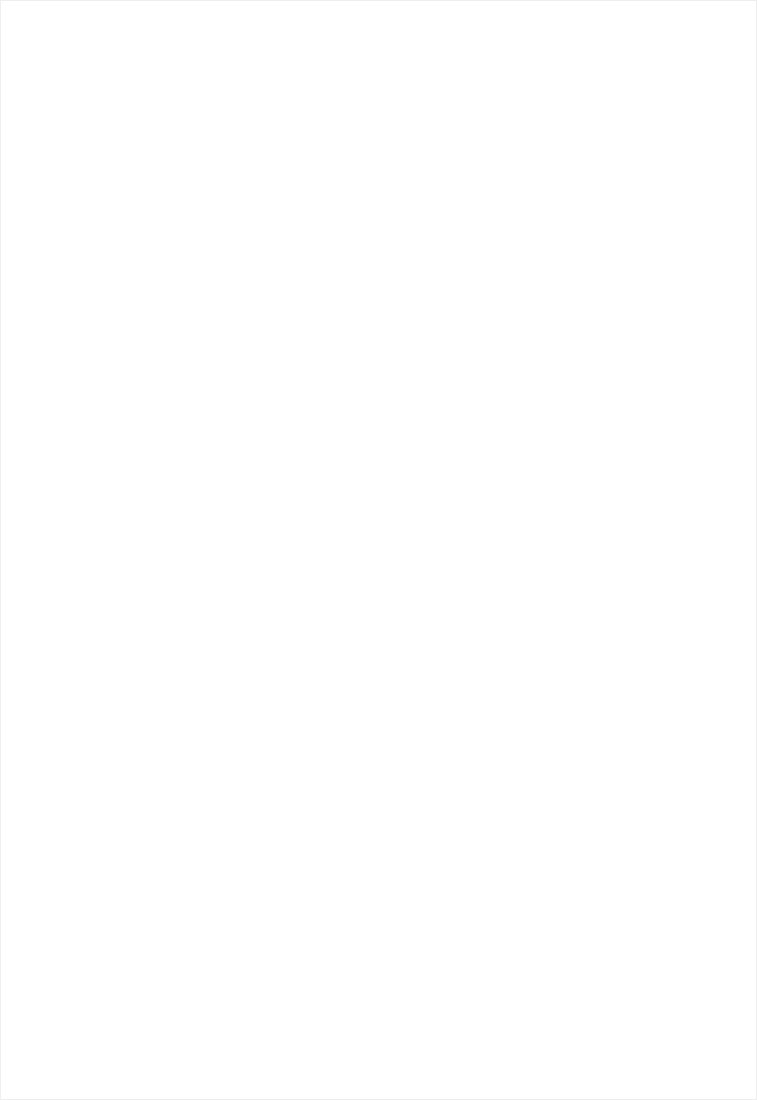

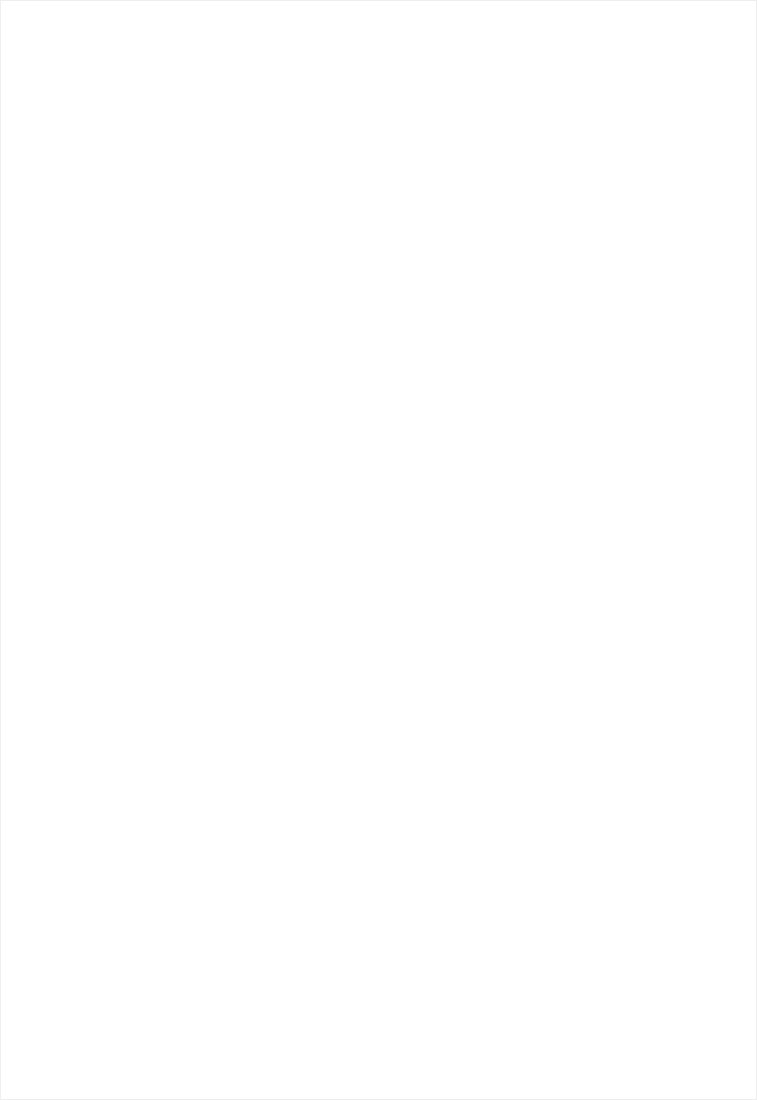